<a href="https://colab.research.google.com/github/fatemeh-ict/NLp/blob/main/MultiheadAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length=4
batch_size=1
input_dim=512
d_model=512
x=torch.randn( (batch_size,sequence_length,input_dim) )

In [3]:
x.shape

torch.Size([1, 4, 512])

In [4]:
qkv_layer=nn.Linear(input_dim,3*d_model)
qkv=qkv_layer(x)


In [5]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

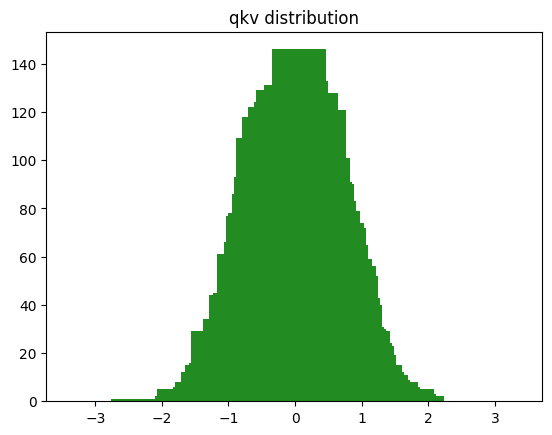

In [6]:
import matplotlib.pyplot as plt
y_val=torch.histc(qkv,bins=200,min=-3,max=3)
x_val=np.arange(-1,1,.01)*3
plt.bar(x_val,y_val,align='center',color=['forestgreen'])
plt.title('qkv distribution')

In [7]:
num_head=8
head_dim=d_model//num_head
qkv=qkv.reshape(batch_size,sequence_length,num_head,3*head_dim)

In [8]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [9]:
qkv=qkv.permute(0,2,1,3)


In [10]:
qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
q,k,v=qkv.chunk(3,dim=-1)

In [12]:
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

Self Attention

In [13]:
import math
d_k=q.size()[-1]
scale=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)

In [14]:
scale.shape

torch.Size([1, 8, 4, 4])

In [15]:
k.T.shape

<ipython-input-15-879c2705464e>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [17]:
y=torch.randn(2,3)
torch.transpose(y,0,1)


tensor([[-1.2358,  0.0309],
        [ 0.3662,  1.2221],
        [ 0.5875,  0.4291]])

In [18]:
torch.transpose(y,1,0)

tensor([[-1.2358,  0.0309],
        [ 0.3662,  1.2221],
        [ 0.5875,  0.4291]])

In [19]:
k.transpose(-1,-2)==k.transpose(-2,-1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [20]:
k.transpose(-1,-2).shape

torch.Size([1, 8, 64, 4])

In [22]:
mask=torch.full(scale.size(),float('-inf'))
mask=torch.triu(mask,diagonal=1)
mask[0][1]


tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [23]:
(scale+mask)[0][0]

tensor([[-0.5064,    -inf,    -inf,    -inf],
        [-0.1236, -0.5560,    -inf,    -inf],
        [ 0.1705,  0.6245, -0.3068,    -inf],
        [ 0.1615,  0.1666, -0.2519,  0.4000]], grad_fn=<SelectBackward0>)

In [24]:
scale+=mask

In [25]:
np.exp(-.1236)/(np.exp(-.1236)+np.exp(-.5560))

0.6064466204106757

In [26]:
attention=F.softmax(scale,dim=-1)

In [27]:
attention.shape

torch.Size([1, 8, 4, 4])

In [28]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6064, 0.3936, 0.0000, 0.0000],
        [0.3130, 0.4928, 0.1942, 0.0000],
        [0.2541, 0.2554, 0.1680, 0.3225]], grad_fn=<SelectBackward0>)

In [29]:
values=torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

Function

In [43]:
def scale_dot_product (q,k,v,mask=None):
  d_k=q.size()[-1]
  scale=torch.matmul(q,k.transpose(-1,-2)/math.sqrt(d_k))
  if mask is not None:
    scale += mask
    attention=F.softmax(scale,dim=-1)
    values=torch.matmul(attention,v)
    return values,attention


In [44]:
values,attention=scale_dot_product(q,k,v,mask=mask)


In [45]:
attention.shape

torch.Size([1, 8, 4, 4])

In [46]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6064, 0.3936, 0.0000, 0.0000],
        [0.3130, 0.4928, 0.1942, 0.0000],
        [0.2541, 0.2554, 0.1680, 0.3225]], grad_fn=<SelectBackward0>)

In [47]:
values.size()

torch.Size([1, 8, 4, 64])

In [48]:
values=values.reshape(batch_size,sequence_length,num_head*head_dim)

In [49]:
values.size()

torch.Size([1, 4, 512])

In [50]:
linear_layer=nn.Linear(d_model,d_model)

In [51]:
out=linear_layer(values)

In [52]:
out.shape

torch.Size([1, 4, 512])

In [53]:
out

tensor([[[-0.1682,  0.4945,  0.2678,  ..., -0.0112,  0.2400,  0.1018],
         [ 0.5724, -0.1793, -0.3729,  ..., -0.2740, -0.0369, -0.3258],
         [-0.1670,  0.2595, -0.0535,  ...,  0.0276,  0.4138,  0.1589],
         [ 0.1075,  0.5408,  0.2852,  ..., -0.1615,  0.2658, -0.0078]]],
       grad_fn=<ViewBackward0>)

Class

In [54]:
import torch
import torch.nn as nn
import math

def scale_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scale = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scale += mask
    attention = F.softmax(scale, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_head):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_head = num_head
        self.head_dim = d_model // num_head
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(x.size())
        qkv = self.qkv_layer(x)
        print(qkv.size())
        qkv = qkv.reshape(batch_size, sequence_length, self.num_head, 3 * self.head_dim)
        print(qkv.size())
        qkv = qkv.permute(0, 2, 1, 3)
        print(qkv.size())
        q, k, v = qkv.chunk(3, dim=-1)
        print(q.size(),  k.size(), v.size())
        values, attention = scale_dot_product(q, k, v, mask)
        print(values.size(),  attention.size())
        values = values.reshape(batch_size, sequence_length, self.num_head * self.head_dim)
        print(values.size())
        out = self.linear_layer(values)
        print(out.size())
        return out

Input

In [55]:
input_dim = 1024
d_model = 512
num_head = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_head)
out = model.forward(x)

torch.Size([30, 5, 1024])
torch.Size([30, 5, 1536])
torch.Size([30, 5, 8, 192])
torch.Size([30, 8, 5, 192])
torch.Size([30, 8, 5, 64]) torch.Size([30, 8, 5, 64]) torch.Size([30, 8, 5, 64])
torch.Size([30, 8, 5, 64]) torch.Size([30, 8, 5, 5])
torch.Size([30, 5, 512])
torch.Size([30, 5, 512])
